In [1]:
import pandas as pd
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = 'data.csv'
tickers = ['VOO', 'IEMG', 'GLDM', 'TLT', 'HYG']

print(f"Loading {data_path}...")
data = pd.read_csv(data_path)
data['DateTime'] = pd.to_datetime(data['DateTime'], utc=True).dt.tz_convert('US/Eastern')
data.set_index('DateTime', inplace=True)
data.sort_index(inplace=True)

print(f"Data loaded: {len(data)} rows, {data.index[0]} to {data.index[-1]}")
data.head()

Loading data.csv...
Data loaded: 33367 rows, 2025-08-04 05:30:00-04:00 to 2025-12-03 10:59:00-05:00


/var/folders/b_/87z_y1k156v1lhn4cngf1jgr0000gn/T/ipykernel_21854/1233333047.py:5: DtypeWarning: Columns (8,16,24,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


,VOO_Time Interval,VOO_Close,VOO_Net Chg,VOO_Open,VOO_High,VOO_Low,VOO_Tick Count,VOO_Volume,IEMG_Time Interval,IEMG_Close,...,TLT_Tick Count,TLT_Volume,HYG_Time Interval,HYG_Close,HYG_Net Chg,HYG_Open,HYG_High,HYG_Low,HYG_Tick Count,HYG_Volume
DateTime,,,,,,,,,,,,,,,,,,,,,
2025-08-04 05:30:00-04:00,09:30 - 09:31,575.655,4.205,575.17,575.71,575.08,304.0,175024.0,09:30 - 09:31,60.62,...,602.0,306292.0,09:30 - 09:31,80.135,0.155,80.090,80.1350,80.06,300.0,301837.0
2025-08-04 05:31:00-04:00,09:31 - 09:32,575.910,0.255,575.67,575.91,575.44,164.0,351220.0,09:31 - 09:32,60.60,...,696.0,501318.0,09:31 - 09:32,80.145,0.010,80.135,80.1500,80.13,125.0,53623.0
2025-08-04 05:32:00-04:00,09:32 - 09:33,575.945,0.035,575.93,576.00,575.80,95.0,205298.0,09:32 - 09:33,60.62,...,325.0,125128.0,09:32 - 09:33,80.130,-0.015,80.145,80.1500,80.13,70.0,30220.0
2025-08-04 05:33:00-04:00,09:33 - 09:34,576.040,0.095,575.99,576.22,575.99,192.0,52291.0,09:33 - 09:34,60.61,...,215.0,65273.0,09:33 - 09:34,80.125,-0.005,80.135,80.1357,80.12,72.0,27951.0
2025-08-04 05:34:00-04:00,09:34 - 09:35,576.180,0.140,576.00,576.24,575.96,96.0,20358.0,09:34 - 09:35,60.60,...,137.0,60679.0,09:34 - 09:35,80.115,-0.010,80.120,80.1300,80.11,56.0,25344.0


In [3]:
def generate_volatility_forecast(data, ticker, limit=None):
    print(f"Processing volatility for {ticker}...")
    
    # Extract relevant series
    close = data[f'{ticker}_Close']
    
    # Calculate returns
    returns = close.pct_change()
    
    # Drop NaNs for the model fitting (usually just the first row)
    returns = returns.dropna()
    
    if limit:
        returns = returns.iloc[:limit]
    
    # Create a Series for the forecast aligned with returns
    volatility_forecast = pd.Series(index=returns.index, dtype=float)
    volatility_forecast[:] = np.nan

    # Start with the first 100 data points
    # For each day, recalibrate the model and generate a volatility forecast for the next day
    for index in range(100, len(returns)):
            
        train_data = returns.iloc[:index]
        
        # rescale=True automatically scales data for optimization
        model = arch_model(train_data, vol='Garch', p=1, q=1, rescale=True)
        model_fit = model.fit(disp='off', show_warning=False)
        
        forecast = model_fit.forecast(horizon=1)
        
        # The forecast is in the scaled units, so we must divide by the scale factor
        vol_f = np.sqrt(forecast.variance.values[-1, 0]) / model_fit.scale
        volatility_forecast.iloc[index] = vol_f

    # Fill the first 100 data points with a rolling standard deviation
    volatility_forecast.iloc[:100] = returns.iloc[:100].rolling(window=20, min_periods=1).std()

    # Backfill
    volatility_forecast = volatility_forecast.bfill()
    
    return volatility_forecast

In [4]:
import os

volatility_forecasts = pd.DataFrame(index=data.index)
output_file = 'volatility_forecasts.csv'

# Load existing results
if os.path.exists(output_file):
    print(f"Loading existing results from {output_file}...")
    existing_df = pd.read_csv(output_file, index_col=0, parse_dates=True)
    if existing_df.index.tz is None:
        existing_df.index = existing_df.index.tz_localize('UTC').tz_convert('US/Eastern')
    else:
        existing_df.index = existing_df.index.tz_convert('US/Eastern')
    volatility_forecasts = existing_df.combine_first(volatility_forecasts)

for ticker in tickers:
    if ticker in volatility_forecasts.columns and not volatility_forecasts[ticker].isna().all():
        print(f"Skipping {ticker}, already calculated.")
        continue

    try:
        # Pass the main data df and ticker
        forecast_series = generate_volatility_forecast(data, ticker)
        
        # Align
        volatility_forecasts[ticker] = forecast_series.reindex(volatility_forecasts.index)
        
        volatility_forecasts.to_csv(output_file)
        print(f"Saved {ticker} to {output_file}")
        
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

volatility_forecasts.head()

Processing volatility for VOO...
Saved VOO to volatility_forecasts.csv
Processing volatility for IEMG...
Saved IEMG to volatility_forecasts.csv
Processing volatility for GLDM...
Saved GLDM to volatility_forecasts.csv
Processing volatility for TLT...
Saved TLT to volatility_forecasts.csv
Processing volatility for HYG...
Saved HYG to volatility_forecasts.csv


,VOO,IEMG,GLDM,TLT,HYG
DateTime,,,,,
2025-08-04 05:30:00-04:00,NaN,NaN,NaN,NaN,NaN
2025-08-04 05:31:00-04:00,0.000270,0.000467,0.000323,0.000201,0.000221
2025-08-04 05:32:00-04:00,0.000270,0.000467,0.000323,0.000201,0.000221
2025-08-04 05:33:00-04:00,0.000198,0.000343,0.000316,0.000143,0.000157
2025-08-04 05:34:00-04:00,0.000162,0.000286,0.000259,0.000128,0.000135


<Axes: title={'center': 'VOO Volatility Forecast'}, xlabel='DateTime'>

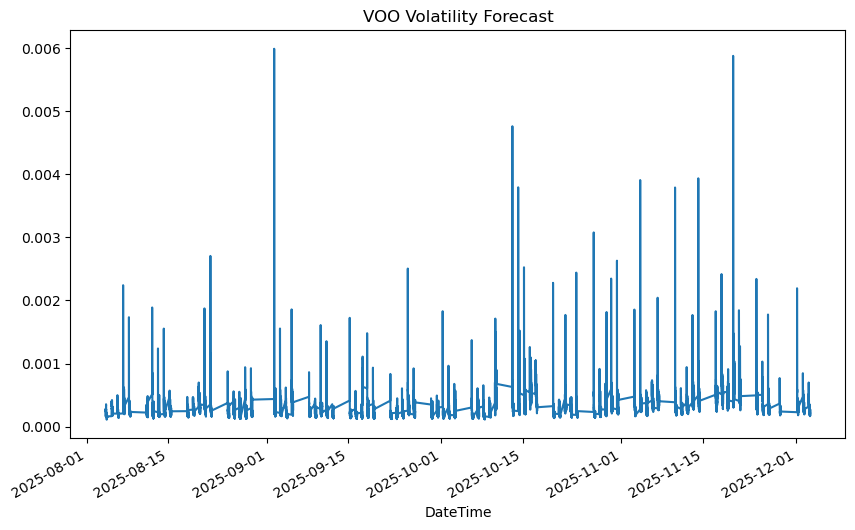

In [5]:
volatility_forecasts['VOO'].plot(title='VOO Volatility Forecast', figsize=(10, 6))

In [6]:
def calculate_alpha_101(data, ticker):
    # Extract columns
    close = pd.to_numeric(data[f'{ticker}_Close'], errors='coerce')
    open_ = pd.to_numeric(data[f'{ticker}_Open'], errors='coerce')
    high = pd.to_numeric(data[f'{ticker}_High'], errors='coerce')
    low = pd.to_numeric(data[f'{ticker}_Low'], errors='coerce')
    
    # Alpha #101: (Close - Open) / ((High - Low) + 0.001)
    alpha_101 = (close - open_) / ((high - low) + 0.001)
    
    return alpha_101

In [7]:
alpha_101_df = pd.DataFrame(index=data.index)

for ticker in tickers:
    print(f"Calculating Alpha 101 for {ticker}...")
    try:
        signal = calculate_alpha_101(data, ticker)
        alpha_101_df[ticker] = signal
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

output_file_a101 = 'A101.csv'
alpha_101_df.to_csv(output_file_a101)
print(f"Saved Alpha 101 signals to {output_file_a101}")
alpha_101_df.head()

Calculating Alpha 101 for VOO...
Calculating Alpha 101 for IEMG...
Calculating Alpha 101 for GLDM...
Calculating Alpha 101 for TLT...
Calculating Alpha 101 for HYG...
Saved Alpha 101 signals to A101.csv


,VOO,IEMG,GLDM,TLT,HYG
DateTime,,,,,
2025-08-04 05:30:00-04:00,0.768621,0.392157,0.967213,0.303030,0.592105
2025-08-04 05:31:00-04:00,0.509554,-0.277778,0.967742,-0.121951,0.476190
2025-08-04 05:32:00-04:00,0.074627,0.326087,-0.483092,-0.588235,-0.714286
2025-08-04 05:33:00-04:00,0.216450,-0.714286,-0.694444,-0.576923,-0.598802
2025-08-04 05:34:00-04:00,0.640569,0.000000,0.238095,-0.721951,-0.238095


In [8]:
def calculate_alpha_6(data, ticker):
    open_ = pd.to_numeric(data[f'{ticker}_Open'], errors='coerce')
    volume = pd.to_numeric(data[f'{ticker}_Volume'], errors='coerce')
    
    # Alpha #6: -1 * Correlation(Open, Volume, 10)
    alpha_6 = -1 * open_.rolling(window=10).corr(volume)
    
    return alpha_6

alpha_6_df = pd.DataFrame(index=data.index)

for ticker in tickers:
    print(f"Calculating Alpha 6 for {ticker}...")
    try:
        signal = calculate_alpha_6(data, ticker)
        alpha_6_df[ticker] = signal
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Backfill
alpha_6_df = alpha_6_df.bfill()

output_file_a6 = 'A6.csv'
alpha_6_df.to_csv(output_file_a6)
print(f"Saved Alpha 6 signals to {output_file_a6}")
alpha_6_df.head()

Calculating Alpha 6 for VOO...
Calculating Alpha 6 for IEMG...
Calculating Alpha 6 for GLDM...
Calculating Alpha 6 for TLT...
Calculating Alpha 6 for HYG...
Saved Alpha 6 signals to A6.csv


,VOO,IEMG,GLDM,TLT,HYG
DateTime,,,,,
2025-08-04 05:30:00-04:00,0.702006,0.030711,0.124285,-0.264992,0.632405
2025-08-04 05:31:00-04:00,0.702006,0.030711,0.124285,-0.264992,0.632405
2025-08-04 05:32:00-04:00,0.702006,0.030711,0.124285,-0.264992,0.632405
2025-08-04 05:33:00-04:00,0.702006,0.030711,0.124285,-0.264992,0.632405
2025-08-04 05:34:00-04:00,0.702006,0.030711,0.124285,-0.264992,0.632405
